<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu RNN**

**Atributi:** Close

**Filtrirani podaci:** od 28.03.2021.

## **Ucitavanje biblioteka**

In [2]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## **Ucitavanje skupa podataka i pretprocesiranje**

In [1]:
# %run preprocessing.ipynb

# data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [3]:
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data = data.dropna()
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)
data = data.loc[data['Date'] > pd.to_datetime('2021-03-28')]
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29


## **Podela skupa, vizualizacija**



### **Podela skupa podataka**

In [4]:
###### DELETE

def data_split(data, test_size = 0):

  if test_size <= 0:
    print('Vrednost parametra test_size mora biti strogo veca od 0.\n')
    return
  else: # test_size > 0
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [5]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)

# Podela train skupa podataka na train i validation skup

train, validation = data_split(data, test_size = 0.2)

In [6]:
# Dimenzije train i test skupa

train.shape, validation.shape, test.shape

((2298, 9), (574, 9), (574, 9))

### **Vizualizacija podataka**

In [7]:
##### DELETE

def plot_train_and_validation_data(train, validation):
  plt.title('Podaci za trening i validaciju')
  plt.xlabel('vreme')
  plt.ylabel('vrednost bitkoina')
  plt.plot(train, c = 'lime')
  plt.plot(validation, c = 'orchid')
  plt.show()

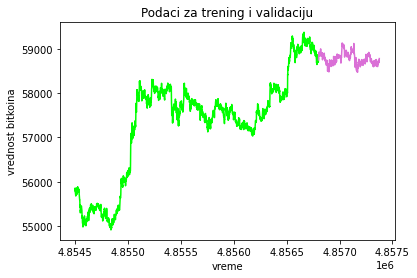

In [8]:
# Plotovanje train i test skupa podataka

plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

## **Priprema trening skupa**

## **Filtriranje atributa train skupa**

In [9]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Close
4854496,55804.36
4854497,55857.28
4854498,55779.04
4854500,55768.63
4854501,55742.20


In [10]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
validation_.head()

,Close
4856801,58747.90
4856802,58825.89
4856803,58828.09
4856804,58835.62
4856805,58900.00


In [11]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
test_.head()

,Close
4856801,58747.90
4856802,58825.89
4856803,58828.09
4856804,58835.62
4856805,58900.00


In [12]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((2298, 9), (2298, 1))

## **Skaliranje**

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_ = scaler.fit_transform(train_)
print(train_)

validation_ = scaler.transform(validation_)
print(validation_)

test_ = scaler.transform(test_)
print(test_)

[[0.19947492]
 [0.21134984]
 [0.19379327]
 ...
 [0.84805843]
 [0.84788789]
 [0.86661356]]
[[0.85998721]
 [0.87748769]
 [0.87798135]
 [0.87967104]
 [0.89411752]
 [0.88930875]
 [0.90001683]
 [0.892365  ]
 [0.89619765]
 [0.89169631]
 [0.88706482]
 [0.883111  ]
 [0.890976  ]
 [0.88471541]
 [0.87884078]
 [0.884592  ]
 [0.89078527]
 [0.88658461]
 [0.90969494]
 [0.91040627]
 [0.91591065]
 [0.91091788]
 [0.89896891]
 [0.89149435]
 [0.890884  ]
 [0.88585758]
 [0.88617173]
 [0.88167488]
 [0.88606626]
 [0.88514625]
 [0.88289782]
 [0.88189703]
 [0.87901581]
 [0.88255226]
 [0.89066185]
 [0.89656341]
 [0.87681675]
 [0.87034523]
 [0.86045844]
 [0.87162876]
 [0.87796789]
 [0.88213264]
 [0.87951845]
 [0.88105106]
 [0.88396594]
 [0.88037115]
 [0.87892156]
 [0.88267343]
 [0.86943419]
 [0.87643304]
 [0.88933119]
 [0.88828776]
 [0.88823391]
 [0.88563543]
 [0.89429703]
 [0.88533474]
 [0.87291678]
 [0.8683571 ]
 [0.863398  ]
 [0.85969325]
 [0.85709253]
 [0.85961472]
 [0.8729841 ]
 [0.87084338]
 [0.85860494]


## **Odredjivanje ciljne promenljive**

In [14]:
##### DELETE

def determine_x_and_y(dataset):
  X = []
  y = []

  df = pd.DataFrame()

  for i in range(60, dataset.shape[0]):
    X.append(dataset[i-60:i])
    y.append(dataset[i,0])
  
  return X, y

# train.shape = 100
# i in (60, 100)
# x_train.append(train[i-60:i])
# y_train.append(train[i, 0])

# i = 61
# x_train - train[1:61]
# y_train - train[61, 0]

# i = 62
# x_train - train[1:61] + train[2:62]
# y_train - train[61, 0] + train[62, 0]

# ...

# i = 99
# x_train - train[1:61] + train[2:62] + ... + train[33:99]
# y_train - train[61, 0] + train[62, 0] + ... + train[99, 0]


In [15]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_)


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_)


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_)

In [16]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [17]:
# Dimenzije X_train

X_train.shape

(2238, 60, 1)

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [18]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [19]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

### **Kompilacija i treniranje mreze**

In [24]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer, loss, metrics, X_train_, y_train_, epochs, validation, validation_data = None, batch_size = 50, patience = 3):

  net.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0:
    history = net.fit(X_train_, y_train_, epochs = epochs, batch_size = batch_size, callbacks=[callback])
  else:
    history = net.fit(X_train_, y_train_, epochs = epochs, validation_data = validation_data, batch_size = batch_size, callbacks=[callback])

  return history, net


In [25]:
# Kompilacija i treniranje mreze sa validacijom

history_validation, net_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 1, validation_data = (X_validation, y_validation), batch_size = 50, patience=3)


# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0, batch_size = 50, patience=3)


Epoch 1/20
45/45 [==============================] - 16s 244ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0738 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0707
Epoch 2/20
45/45 [==============================] - 10s 228ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0554 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0525
Epoch 3/20
45/45 [==============================] - 10s 228ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0536 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0587
Epoch 4/20
45/45 [==============================] - 10s 231ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0567 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1323
Epoch 5/20
45/45 [==============================] - 10s 228ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0555 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0922
Epoch 6/20
45/45 [==============================] - 10s 230ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0549 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.1082
Epoch 1/20

## **Predvidjanje**

In [26]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti (prvih 10) - bez validacije:\n', y_predicted_no_validation[:10])

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti (prvih 10) - sa validacijom:\n', y_predicted_validation[:10])

Predvidjene vrednosti (prvih 10) - bez validacije:
 [[0.7939732 ]
 [0.793577  ]
 [0.7928764 ]
 [0.7919604 ]
 [0.790928  ]
 [0.7898187 ]
 [0.7886526 ]
 [0.7874226 ]
 [0.78613263]
 [0.7848194 ]]

Predvidjene vrednosti (prvih 10) - sa validacijom:
 [[0.7939732 ]
 [0.793577  ]
 [0.7928764 ]
 [0.7919604 ]
 [0.790928  ]
 [0.7898187 ]
 [0.7886526 ]
 [0.7874226 ]
 [0.78613263]
 [0.7848194 ]]


## **Vizualizacija rezultata predvidjanja i metrika**

### **Vizuelni prikaz predvidjene i stvarne vrednosti**

In [45]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set):

  fig, ax = plt.subplots(1, figsize=(7, 5))
  ax.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  ax.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  ax.set_xlabel('Redni broj instance', fontsize=14)
  ax.set_ylabel('Cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  ax.legend(loc='best')

  # test = test.reset_index()
  # x = test.index


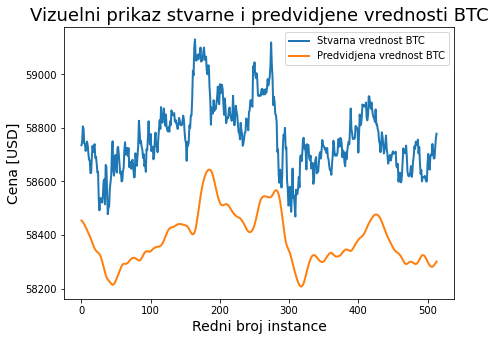

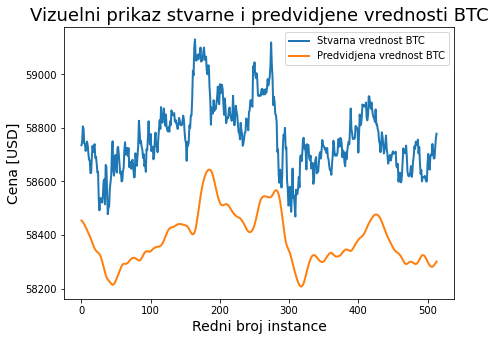

In [46]:
# Plotovanje stvarne i predvidjene vrednosti

test_set = scaler.inverse_transform(y_test.reshape(-1,1))
no_validation_data = scaler.inverse_transform(y_predicted_no_validation.reshape(-1,1))
validation_data = scaler.inverse_transform(y_predicted_validation.reshape(-1,1))

# Bez validacije
plot_real_vs_predicted_data(test_set = test_set, predicted_set = no_validation_data)

# Sa validacijom
plot_real_vs_predicted_data(test_set = test_set, predicted_set = validation_data)

### **Vizuelni prikaz gubitka, tacnosti i srednje apsolutne greske tokom treniranja mreze (sa i bez validacije)**

In [29]:
# Vizuelni prikaz gubitka

def plot_loss(history_):

  epochs = range(len(history_.history['loss'])) # broj epoha
  plt.title('Vizuelni prikaz gubitka (loss)')
  plt.xlabel('broj epohe')
  plt.ylabel('gubitak')

  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if 'val_loss' in history_.history:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


In [30]:
# Vizuelni prikaz tacnosti

def plot_mse(history_):

  epochs = range(len(history_.history['mse'])) # broj epoha
  plt.title('Vizuelni prikaz MSE (mse')
  plt.xlabel('broj epohe')
  plt.ylabel('tacnost')
  
  plt.plot(epochs, history_.history['mse'], label='MSE (mse) tokom treniranja')

  if 'val_mse' in history_.history:
    plt.plot(epochs, history_.history['val_mse'], label='MSE (val_mse) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


In [31]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


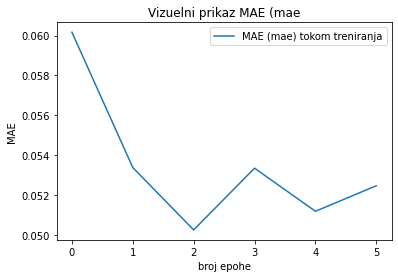

In [32]:
# MAE

plot_mae(history_no_validation)

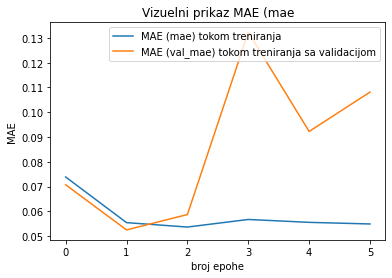

In [33]:
# MAE - sa validacijom

plot_mae(history_validation)

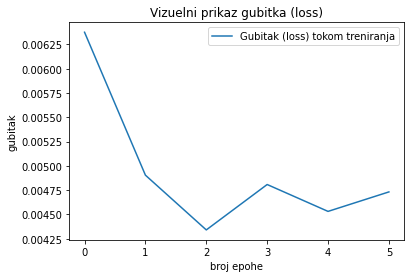

In [34]:
# Loss

plot_loss(history_no_validation)

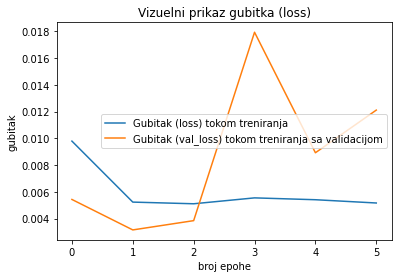

In [35]:
# Loss - sa validacijom

plot_loss(history_validation)

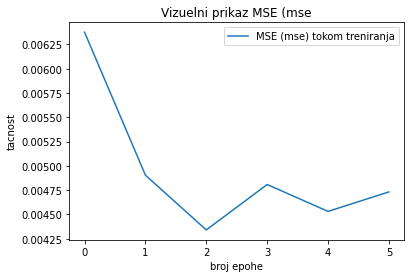

In [36]:
# MSE

plot_mse(history_no_validation)

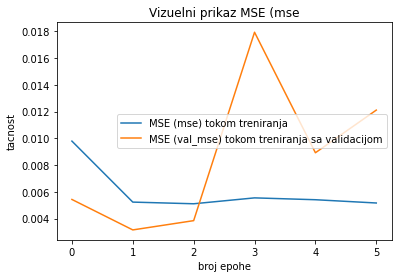

In [37]:
# MSE - validation

plot_mse(history_validation)

In [38]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])


17/17 [==============================] - 1s 49ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0845

Metrike prilikom testiranja - model treniran bez validacije

loss 0.007511357311159372
mse 0.007511357311159372
mae 0.08445429056882858


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.007511357311159372
mse 0.007511357311159372
mae 0.08445429056882858


In [39]:
# R2 skor nad skupom za testiranje

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -14.229146521684106
R2 skor prilikom testiranja - model treniran sa validacijom -14.229146521684106
